In [1]:
import chess
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
df = pd.read_parquet('../data/data_2025_01.parquet')
df.tail()

,game_id,event,white_elo,black_elo,opening,winner,moves
9982296,9999996,Rated Blitz game,1586,1593,"Sicilian Defense: Delayed Alapin Variation, wi...",1,e2e4 c7c5 g1f3 e7e6 c2c3 d7d5 e4d5 e6d5 d2d4 c...
9982297,9999997,Rated Blitz game,2094,2106,Ruy Lopez: Berlin Defense,2,e2e4 b8c6 g1f3 e7e5 f1b5 g8f6 b5c6 b7c6 f3e5 f...
9982298,9999998,Rated Blitz game,1449,1532,Scandinavian Defense: Main Line,1,e2e4 d7d5 e4d5 d8d5 b1c3 d5a5 d2d3 c7c6 c1d2 g...
9982299,9999999,Rated Blitz game,2069,2063,Sicilian Defense: Kramnik Variation,1,e2e4 c7c5 g1f3 e7e6 c2c4 b8c6 d2d3 d7d6 b1c3 g...
9982300,10000000,Rated Blitz game,1292,1283,King's Pawn Game: Leonardis Variation,2,e2e4 e7e5 d2d3 g8f6 g1f3 b8c6 f1e2 f8e7 e1g1 d...


In [3]:
df["event"].value_counts()

event
Rated Blitz game                                                  4231136
Rated Bullet game                                                 3355083
Rated Rapid game                                                  1340401
Rated Classical game                                                56249
Rated UltraBullet game                                              46917
                                                                   ...   
Classical swiss https://lichess.org/swiss/bUvNze57                      1
Rated Rapid tournament https://lichess.org/tournament/wmyH1zNY          1
Rated Rapid tournament https://lichess.org/tournament/3XeES9oL          1
Blitz swiss https://lichess.org/swiss/UUugSTaP                          1
Rapid swiss https://lichess.org/swiss/WReDpHLY                          1
Name: count, Length: 4664, dtype: int64

In [4]:
df["opening"].value_counts()

opening
Queen's Pawn Game                                                     261820
Caro-Kann Defense                                                     185052
Van't Kruijs Opening                                                  176273
Modern Defense                                                        163143
Philidor Defense                                                      159803
                                                                       ...  
Sicilian Defense: Kan Variation, Wing Attack, Christiansen's Dream         1
Petrov's Defense: Modern Attack, Tal Gambit                                1
Scandinavian Defense: Modern Variation, Wing Gambit                        1
Italian Game: Classical Variation, Eisinger Variation                      1
King's Gambit Declined: Classical Variation, Euwe Attack                   1
Name: count, Length: 2914, dtype: int64

In [5]:
events_to_keep = [
    "Rated Bullet game",
    "Rated Blitz game",
    "Rated Rapid game",
    "Rated Classical game"
]
df = df[df["event"].isin(events_to_keep)]

df = df[df["opening"] == "Queen's Pawn Game: Accelerated London System"]

df.head()

,game_id,event,white_elo,black_elo,opening,winner,moves
23,25,Rated Blitz game,1433,1491,Queen's Pawn Game: Accelerated London System,2,d2d4 d7d5 c1f4 g8f6 e2e3 c8g4 f1e2 g4e2 g1e2 e...
34,36,Rated Blitz game,1773,1654,Queen's Pawn Game: Accelerated London System,0,d2d4 d7d5 c1f4 c7c6 g1f3 c8f5 h2h3 e7e6 b1d2 h...
179,181,Rated Blitz game,1725,1756,Queen's Pawn Game: Accelerated London System,2,d2d4 d7d5 c1f4 g8f6 e2e3 e7e6 c2c3 c7c5 f1d3 c...
253,255,Rated Rapid game,2217,2248,Queen's Pawn Game: Accelerated London System,1,d2d4 d7d5 c1f4 f7f6 e2e3 h7h5 f1d3 e8f7 h2h4 a...
265,267,Rated Rapid game,1443,1479,Queen's Pawn Game: Accelerated London System,1,d2d4 d7d5 c1f4 e7e6 e2e3 f8d6 f4g3 g8f6 g1f3 d...


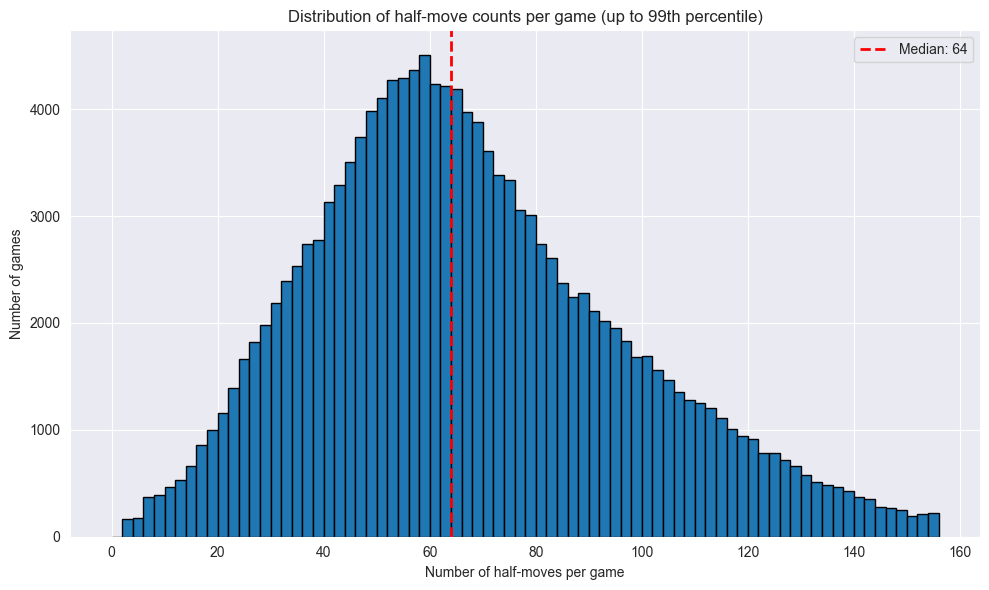

In [6]:
# Count number of half-moves (plies) per game
df["num_halfmoves"] = df["moves"].apply(lambda x: len(x.split()))
median_val = df["num_halfmoves"].median()

# Cap the histogram at the 99th percentile to avoid skew from outliers
upper_limit = df["num_halfmoves"].quantile(0.99)

plt.figure(figsize=(10, 6))
plt.hist(df["num_halfmoves"], bins=range(0, int(upper_limit) + 2, 2), edgecolor='black')
plt.axvline(median_val, color='red', linestyle='dashed', linewidth=2, label=f"Median: {median_val:.0f}")
plt.xlabel("Number of half-moves per game")
plt.ylabel("Number of games")
plt.title("Distribution of half-move counts per game (up to 99th percentile)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Extract positions from the first 25 half-moves of each game
records = []

for _, game in tqdm(df.iterrows(), total=len(df), desc="Processing games"):
    board = chess.Board()
    moves_arr = game["moves"].split()
    winner_flag = game["winner"]

    for idx, mv in enumerate(moves_arr):
        # Stop after 25 half-moves or if there's no next move
        if idx >= 25 or idx + 1 >= len(moves_arr):
            break

        board.push_uci(mv)
        next_move = moves_arr[idx + 1]

        # Determine whether the player to move is on the winning side
        if (board.turn == chess.WHITE and winner_flag == 1) or (board.turn == chess.BLACK and winner_flag == 2):
            win_pov = True
        else:
            win_pov = False

        played_by = game["white_elo"] if board.turn else game["black_elo"]

        records.append({
            "fen": board.fen(),
            "next_move": next_move,
            "played_by_elo": played_by,
            "win_pov": win_pov
        })

positions_df = pd.DataFrame.from_records(records)
positions_df.head()

Processing games: 100%|██████████| 145903/145903 [02:11<00:00, 1112.34it/s]


,fen,next_move,played_by_elo,win_pov
0,rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...,d7d5,1491,True
1,rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...,c1f4,1433,False
2,rnbqkbnr/ppp1pppp/8/3p4/3P1B2/8/PPP1PPPP/RN1QK...,g8f6,1491,True
3,rnbqkb1r/ppp1pppp/5n2/3p4/3P1B2/8/PPP1PPPP/RN1...,e2e3,1433,False
4,rnbqkb1r/ppp1pppp/5n2/3p4/3P1B2/4P3/PPP2PPP/RN...,c8g4,1491,True


In [8]:
# Count how often each (position, move) pair appears
positions_df["games_count"] = (
    positions_df.groupby(["fen", "next_move"])["fen"].transform("size")
)

# Keep only frequently played position-move pairs
positions_df = positions_df[positions_df["games_count"] >= 100]

n_unique = positions_df[["fen", "next_move"]].drop_duplicates().shape[0]
print(f"{n_unique} unique position–move pairs occurred at least 100 times.")

1103 unique position–move pairs occurred at least 100 times.


In [9]:
positions_df.to_parquet("../data/positions_2025_01.parquet", index=False)
print("✅ Saved position data to 'data/positions_2025_01.parquet'")

✅ Saved position data to 'data/positions_2025_01.parquet'
